In [3]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import sys
import theano.tensor as tt
import seaborn as sns

%matplotlib inline

/Users/claus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We generate some made up spend and transaction data per channel

In [39]:
channels = {
            'FB 201704': [91856, 1824],
            'FB 201705': [82933, 1288],
            'FB 201706': [74216, 629],
            'FB 201707': [70118, 447],
            'FB 201708': [63960, 544],
            'FB 201709': [73708, 898],
            }


df = pd.DataFrame(channels).T.reset_index()
df.columns = ['channel', 'spend', 'transactions']
df.loc[:, 'cost_per_transaction'] = df['spend']/df['transactions']
df

,channel,spend,transactions,cost_per_transaction
0,FB 201704,91856,1824,50.359649
1,FB 201705,82933,1288,64.388975
2,FB 201706,74216,629,117.990461
3,FB 201707,70118,447,156.863535
4,FB 201708,63960,544,117.573529
5,FB 201709,73708,898,82.080178


In [40]:
spend_obs = df['spend'].values
transactions_obs = df['transactions'].values

We calculate the observed cost per transaction so we can compare to the posterior distribution later

In [41]:
cost_per_transaction_obs = df['cost_per_transaction'].values
cost_per_transaction_obs

array([ 50.35964912,  64.38897516, 117.99046105, 156.86353468,
       117.57352941,  82.08017817])

- We model the unobserved (latent) cost per transaction $c$ as a _Uniform_ prior (or alternatively as an Exponential)
- The expected transactions $e$ are modeled deterministically as the observed spend / latent distribution of cost/transaction
- The likelihood of the observed transactions is modeled as a _Poission_ distribution with $mu = e$

In [42]:
model = pm.Model()

with pm.Model() as model:
    # We'll use Exponential as our prior
#     c = pm.Exponential('Prior', 1/50., shape=len(channels))
    c = pm.Uniform('cost_per_transaction_prior', 0, 10000, shape=len(channels))

    e = pm.Deterministic('expected_transactions', spend_obs / c)  
    # The observed number of transactions is a Poisson with mu set to the expectations
    a = pm.Poisson('transactions_likelihood', mu=e, observed=transactions_obs)

In [43]:
model

In [44]:
with model: 
    trace = pm.sample(20000, tune=5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cost_per_transaction_prior_interval__]
100%|██████████| 25000/25000 [00:12<00:00, 1999.68it/s]


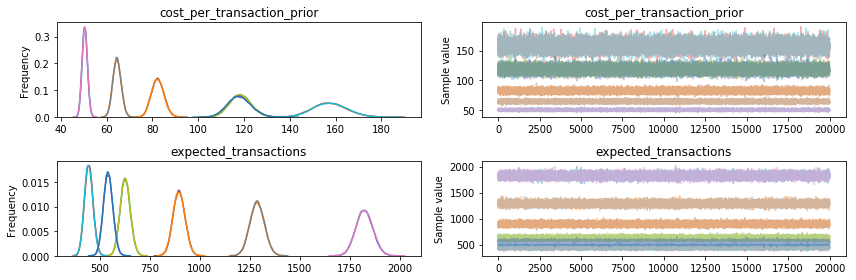

In [45]:
pm.traceplot(trace);

We plot the distributions of the cost per transaction, along with the observed values to see if the model returned reasonable distributions.

We notice that for channels with lower volume, the distributions show some (expected) skew.

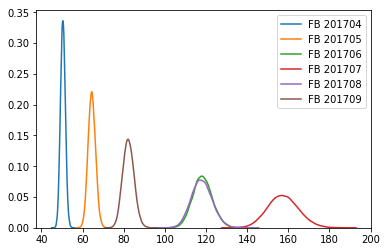

In [51]:
ax = plt.subplot()
for i, c in df.iterrows():
    dt = trace['cost_per_transaction_prior'][:, i]
    sns.distplot(dt, kde=True, hist=False, ax=ax, label=c['channel'])
plt.show()

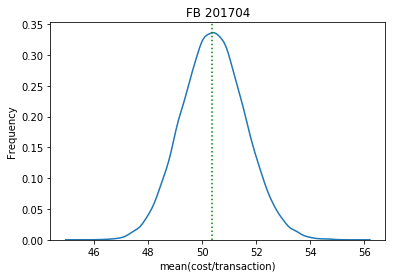

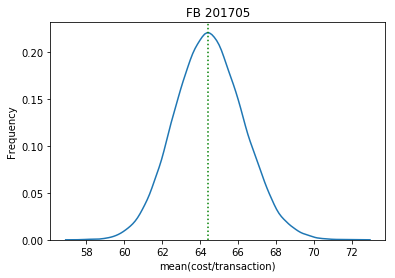

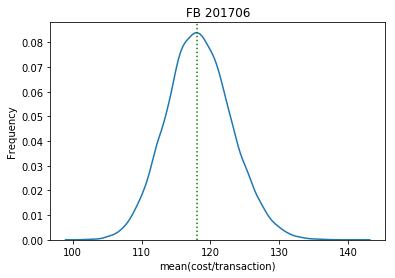

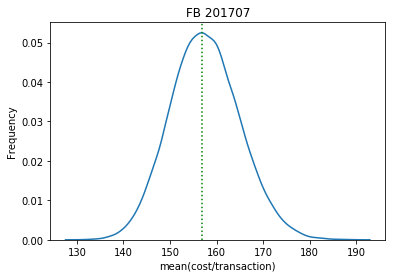

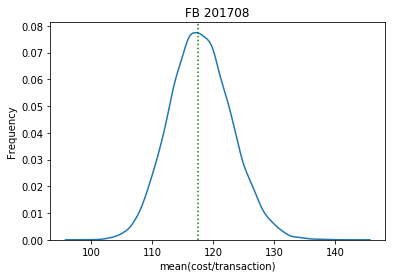

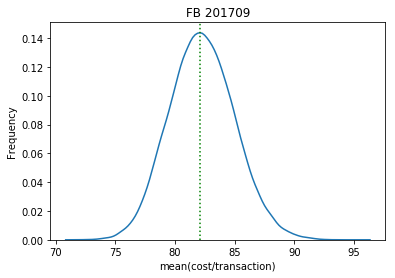

In [46]:
for i, c in df.iterrows():
    dt = trace['cost_per_transaction_prior'][:, i]
    ax = plt.subplot()
    sns.distplot(dt, 
                 kde=True, hist=False, ax=ax)
    ax.axvline(c['cost_per_transaction'], c='g', linestyle='dotted')
    ax.set(title=f'{c["channel"]}', xlabel='mean(cost/transaction)', ylabel='Frequency');
    plt.show()

To get the posterior of the transactions, we sample from the posterior for each channel

In [47]:
with model:
    ppc = pm.sample_ppc(trace)

100%|██████████| 20000/20000 [00:04<00:00, 4732.96it/s]


Then we plot the distributions for each channel along with the observed values:

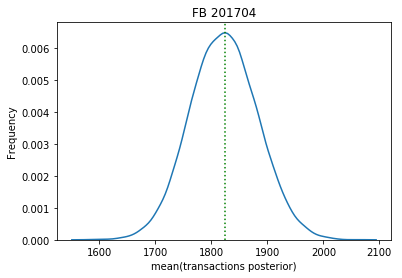

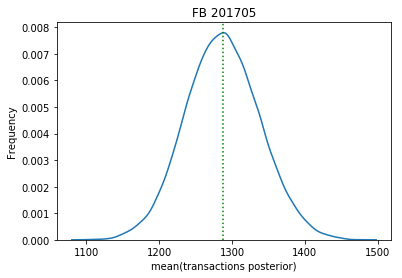

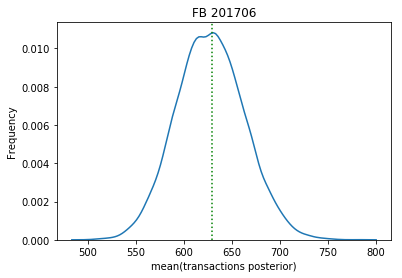

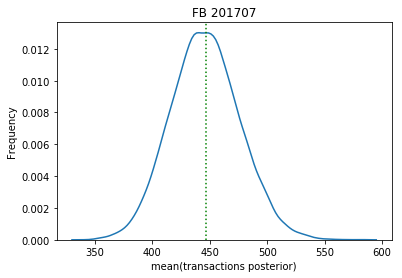

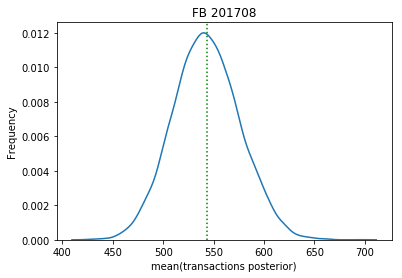

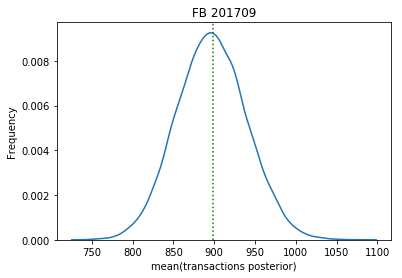

In [48]:
for i, c in df.iterrows():
    dt = ppc['transactions_likelihood'][:, i]
    ax = plt.subplot()
    sns.distplot(dt, 
                 kde=True, hist=False, ax=ax)
    ax.axvline(c['transactions'], c='g', linestyle='dotted')
    ax.set(title=f'{c["channel"]}', xlabel='mean(transactions posterior)', ylabel='Frequency');
    plt.show()